In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle5 as pickle
import math
import matplotlib.pyplot as plt
from matplotlib import colors

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

from helpers import *
import time

#### Prepare raw data
- Create detect and classify labels 
- Add ID from index for identifying specific wafers
- Pre-split into train, dev, test

In [2]:
# load data
with open('WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')
raw_data.head()

Raw data shape: (172950, 11)


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [3]:
# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

raw_data.head()

,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8


In [ ]:
# # split raw data into train, dev, and test sets
# raw_train = raw_data[raw_data.dataset == 'train'].reset_index(drop=True)
# raw_dev = raw_data[raw_data.dataset == 'dev'].reset_index(drop=True)
# raw_test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)
# print(f"Train: {len(raw_train)}")
# print(f"Dev: {len(raw_dev)}")
# print(f"Test: {len(raw_test)}")

#### Create paper datasets
- waferMap resized to 224x224 --> waferMap224
- 7x7 median filter applied

In [5]:
# resize to 224x224
# apply 7x7 median filter
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    z = cv2.medianBlur(new_y, 7)
    return z
    
raw_data['waferMap224'] = raw_data.waferMap.apply(lambda x: preprocess(x))

# check that resizing worked
time = time.time() - start
print(f'Time: {time:.3f} seconds')
print(raw_data.waferMap224[2].shape)

Time: 630.078 seconds
(224, 224)


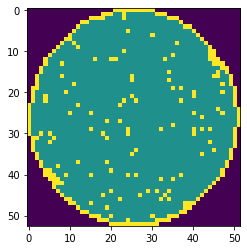

In [6]:
plt.imshow(raw_data.waferMap[23135])

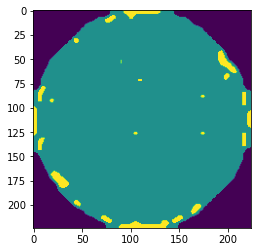

In [7]:
plt.imshow(raw_data.waferMap224[23135])

In [8]:
# keep only columns needed for modeling
paper_data = raw_data[['ID', 'waferMap224', 'dataset', 'detectLabels', 'classifyLabels']]
paper_data.head()

,ID,waferMap224,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,0,8
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",test,0,8
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",test,0,8
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,0,8
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,0,8


In [9]:
# split paper data into train, dev, and test sets
paper_train = paper_data[paper_data.dataset == 'train'].reset_index(drop=True)
paper_dev = paper_data[paper_data.dataset == 'dev'].reset_index(drop=True)
paper_test = paper_data[paper_data.dataset == 'test'].reset_index(drop=True)
print(f"Train: {len(paper_train)}")
print(f"Dev: {len(paper_dev)}")
print(f"Test: {len(paper_test)}")

Train: 121065
Dev: 25942
Test: 25943


In [10]:
# save dev and test sets, keeping only needed columns
paper_dev = paper_dev.drop('dataset', axis=1)
with open('WM-clean-paper-dev.pkl', "wb") as f:
    pickle.dump(paper_dev, f)

paper_test = paper_test.drop('dataset', axis=1)
with open('WM-clean-paper-test.pkl', "wb") as f:
    pickle.dump(paper_test, f)

# sanity check
paper_dev.head()

,ID,waferMap224,detectLabels,classifyLabels
0,15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,8
1,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0
2,24,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,8
3,30,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,8
4,35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1


In [11]:
# create detund dataset
# make list of none indices
none_df = paper_train[paper_train.detectLabels == 0]
none_list = none_df.index.tolist()
print(f'None count: {len(none_list)}')

# make list of defect indices
def_df = paper_train[paper_train.detectLabels == 1]
def_list = def_df.index.tolist()
print(f'Defect count: {len(def_list)}')

# randomly undersample none list
from random import sample, seed
seed(424)
under_none = sample(none_list, 30000)

# recombine defect indices with undersampled none indices
new_list = sorted(under_none + def_list)
print(f'Undersampled dataset count: {len(new_list)}')

# undersample data
undersampled = paper_train.iloc[new_list].reset_index(drop=True)
print(undersampled.shape)
undersampled.head()

None count: 103202
Defect count: 17863
Undersampled dataset count: 47863
(47863, 5)


,ID,waferMap224,dataset,detectLabels,classifyLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,0,8
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,1
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,1
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,1
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train,1,0


In [12]:
# save undersampled dataset, keeping only needed columns
undersampled = undersampled.drop(['dataset', 'classifyLabels'], axis=1)
with open('WM-clean-paper-train-detund.pkl', "wb") as f:
    pickle.dump(undersampled, f)

# sanity check
undersampled.head()

,ID,waferMap224,detectLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [19]:
# create classify dataset (not augmented)
classify = paper_train[paper_train.detectLabels == 1].reset_index(drop=True)
classify = classify.drop(['dataset', 'detectLabels'], axis=1)

# sanity check
print(f'Label range: {classify.classifyLabels.unique()}')
print(f'Number of rows: {len(classify)}')

Label range: [1 0 2 6 5 4 3 7]
Number of rows: 17863


In [20]:
# save classify dataset
with open('WM-clean-paper-train-classify.pkl', "wb") as f:
    pickle.dump(classify, f)
    
# sanity check
classify.head()

,ID,waferMap224,classifyLabels
0,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [28]:
# create knn sanitized dataset
# load IDs of samples correctly classified by KNN
with open('knn_sanitize_ids.pkl', "rb") as fh:
    knn = pickle.load(fh)
print(f'KNN length: {len(knn)}')
knn[:3]

KNN length: 15030


[36, 37, 38]

In [30]:
# subset classify dataset
# get indices corresponding to IDs
correct_indices = [classify.index[classify.ID == i][0] for i in knn]

knn_data = classify.loc[correct_indices].reset_index(drop=True)

print(knn_data.shape)
knn_data.head()

(15030, 3)


,ID,waferMap224,classifyLabels
0,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2


In [31]:
# save knn sanitized dataset
with open('WM-clean-paper-train-knn.pkl', "wb") as f:
    pickle.dump(knn_data, f)